# Data acquitition

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [ ]:
#Load data
file_path = "/content/drive/MyDrive/VR/VR.csv"
df = pd.read_csv(file_path)

### PROFILE DATASET

In [ ]:
#Sample data
df.head()

,UserID,Age,Gender,VRHeadset,Duration,MotionSickness,ImmersionLevel
0,1,40,Male,HTC Vive,13.598508,8,5
1,2,43,Female,HTC Vive,19.950815,2,2
2,3,27,Male,PlayStation VR,16.543387,4,2
3,4,33,Male,HTC Vive,42.574083,6,3
4,5,51,Male,PlayStation VR,22.452647,4,2


In [ ]:
df.shape

(1000, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UserID          1000 non-null   int64  
 1   Age             1000 non-null   int64  
 2   Gender          1000 non-null   object 
 3   VRHeadset       1000 non-null   object 
 4   Duration        1000 non-null   float64
 5   MotionSickness  1000 non-null   int64  
 6   ImmersionLevel  1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB


### Melihat Missing Value dan Duplicated Data

In [ ]:
#Melihat missing value
df.isnull().sum()

,0
UserID,0
Age,0
Gender,0
VRHeadset,0
Duration,0
MotionSickness,0
ImmersionLevel,0


In [ ]:
#Melihat jumlah duplicated data
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,UserID,Age,Duration,MotionSickness,ImmersionLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,39.178000,32.576660,5.526000,2.976000
std,288.819436,12.050208,15.764659,2.866625,1.409756
min,1.000000,18.000000,5.008672,1.000000,1.000000
25%,250.750000,29.000000,18.733748,3.000000,2.000000
50%,500.500000,39.000000,32.368611,6.000000,3.000000
75%,750.250000,49.000000,45.343732,8.000000,4.000000
max,1000.000000,60.000000,59.983723,10.000000,5.000000


In [ ]:
del df['UserID']
print('deleted')

deleted


Feature Engineering


In [ ]:
age_bins = [0, 18, 30, 40, 50, 60]

age_group_dummies = pd.get_dummies(pd.cut(df['Age'], bins=age_bins, labels=['0-18', '19-30', '31-40', '41-50', '51-60'], right=False), prefix='Age')

age_group_dummies = age_group_dummies.astype(int)

df = pd.concat([df, age_group_dummies], axis=1)

In [ ]:
gender_dummies = pd.get_dummies(df['Gender'])

gender_dummies = gender_dummies.astype(int)

df = pd.concat([df, gender_dummies], axis=1)

In [ ]:
vrheadset_dummies = pd.get_dummies(df['VRHeadset'])

vrheadset_dummies = vrheadset_dummies.astype(int)

df = pd.concat([df, vrheadset_dummies], axis=1)

In [ ]:
duration_bins = [5, 15, 25, 35, 45, 55, 65]

duration_group_dummies = pd.get_dummies(pd.cut(df['Duration'], bins=duration_bins, labels=['5-15', '15-25', '25-35', '35-45', '45-55', '55-65'], right=False), prefix='Age')

duration_group_dummies = duration_group_dummies .astype(int)

df = pd.concat([df, duration_group_dummies], axis=1)

In [ ]:
ms_dummies = pd.get_dummies(df['MotionSickness'], prefix='MotionSickness_level')

ms_dummies = ms_dummies.astype(int)

df = pd.concat([df, ms_dummies], axis=1)

# Mapping/Dropping


In [ ]:
df.head()

,Age,Gender,VRHeadset,Duration,MotionSickness,ImmersionLevel,Age_0-18,Age_19-30,Age_31-40,Age_41-50,...,MotionSickness_level_1,MotionSickness_level_2,MotionSickness_level_3,MotionSickness_level_4,MotionSickness_level_5,MotionSickness_level_6,MotionSickness_level_7,MotionSickness_level_8,MotionSickness_level_9,MotionSickness_level_10
0,40,Male,HTC Vive,13.598508,8,5,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,43,Female,HTC Vive,19.950815,2,2,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,27,Male,PlayStation VR,16.543387,4,2,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,33,Male,HTC Vive,42.574083,6,3,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,51,Male,PlayStation VR,22.452647,4,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
del df['Gender']
del df['VRHeadset']
del df['MotionSickness']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      1000 non-null   int64  
 1   Duration                 1000 non-null   float64
 2   ImmersionLevel           1000 non-null   int64  
 3   Age_0-18                 1000 non-null   int64  
 4   Age_19-30                1000 non-null   int64  
 5   Age_31-40                1000 non-null   int64  
 6   Age_41-50                1000 non-null   int64  
 7   Age_51-60                1000 non-null   int64  
 8   Female                   1000 non-null   int64  
 9   Male                     1000 non-null   int64  
 10  Other                    1000 non-null   int64  
 11  HTC Vive                 1000 non-null   int64  
 12  Oculus Rift              1000 non-null   int64  
 13  PlayStation VR           1000 non-null   int64  
 14  Age_5-15                 

# Model Building

In [ ]:
y = df['ImmersionLevel']
X = df.drop('ImmersionLevel', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def model_evaluation(y_pred, y_test=y_test):

    #Mean Absolute Error
    print('*'*70)
    print(f'Mean Absolute Error: {mean_absolute_error(y_pred, y_test)}')
    print('*'*70)

    #accuracy score of the given Metrics
    print(f'Accuracy Score: {accuracy_score(y_pred, y_test)}')
    print('*'*70)

    #Confusion Matrix
    print(f"Confusion Matrix: \n{confusion_matrix(y_pred, y_test)}")
    print('*'*70)

    #classification report
    print(f"Classification Report: \n{classification_report(y_pred, y_test)}")

In [ ]:
lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model_evaluation(lr_pred)

**********************************************************************
Mean Absolute Error: 1.57
**********************************************************************
Accuracy Score: 0.2
**********************************************************************
Confusion Matrix: 
[[11  8  4 11  4]
 [11  8  8  6  9]
 [ 6  5  6  6  8]
 [17 13 12 12 14]
 [ 4  7  5  2  3]]
**********************************************************************
Classification Report: 
              precision    recall  f1-score   support

           1       0.22      0.29      0.25        38
           2       0.20      0.19      0.19        42
           3       0.17      0.19      0.18        31
           4       0.32      0.18      0.23        68
           5       0.08      0.14      0.10        21

    accuracy                           0.20       200
   macro avg       0.20      0.20      0.19       200
weighted avg       0.23      0.20      0.21       200



In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

rf_pred = rf_classifier.predict(X_test)

In [ ]:
model_evaluation(rf_pred)

**********************************************************************
Mean Absolute Error: 1.535
**********************************************************************
Accuracy Score: 0.225
**********************************************************************
Confusion Matrix: 
[[12  8  2  5 10]
 [11 10  9  8  9]
 [12  7 10 10  8]
 [ 9 10  5  6  4]
 [ 5  6  9  8  7]]
**********************************************************************
Classification Report: 
              precision    recall  f1-score   support

           1       0.24      0.32      0.28        37
           2       0.24      0.21      0.23        47
           3       0.29      0.21      0.24        47
           4       0.16      0.18      0.17        34
           5       0.18      0.20      0.19        35

    accuracy                           0.23       200
   macro avg       0.22      0.23      0.22       200
weighted avg       0.23      0.23      0.22       200



In [ ]:
catboost = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    verbose=10
)

catboost.fit(X_train, y_train)

catboost_pred = catboost.predict(X_test)

0:	learn: 1.6072138	total: 47.6ms	remaining: 4.71s
10:	learn: 1.5842489	total: 55.5ms	remaining: 449ms
20:	learn: 1.5678826	total: 63.4ms	remaining: 239ms
30:	learn: 1.5529572	total: 71.3ms	remaining: 159ms
40:	learn: 1.5359825	total: 79.5ms	remaining: 114ms
50:	learn: 1.5234416	total: 87.3ms	remaining: 83.9ms
60:	learn: 1.5118340	total: 96.1ms	remaining: 61.4ms
70:	learn: 1.4985360	total: 104ms	remaining: 42.5ms
80:	learn: 1.4855420	total: 114ms	remaining: 26.7ms
90:	learn: 1.4723143	total: 122ms	remaining: 12ms
99:	learn: 1.4610390	total: 129ms	remaining: 0us


In [ ]:
model_evaluation(catboost_pred)

**********************************************************************
Mean Absolute Error: 1.59
**********************************************************************
Accuracy Score: 0.2
**********************************************************************
Confusion Matrix: 
[[ 9 10  6  6  4]
 [ 7 10 11 10  9]
 [10  4  7  8  7]
 [13 11  7  8 12]
 [10  6  4  5  6]]
**********************************************************************
Classification Report: 
              precision    recall  f1-score   support

           1       0.18      0.26      0.21        35
           2       0.24      0.21      0.23        47
           3       0.20      0.19      0.20        36
           4       0.22      0.16      0.18        51
           5       0.16      0.19      0.17        31

    accuracy                           0.20       200
   macro avg       0.20      0.20      0.20       200
weighted avg       0.21      0.20      0.20       200



# Optimasi


In [ ]:
def objective(space):
    model = CatBoostClassifier(
        learning_rate=space['learning_rate'],
        depth=int(space['depth']),
        l2_leaf_reg=space['l2_leaf_reg'],
        iterations=100,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=False
    )

    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

In [ ]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 5),
}


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best params", best)

100%|██████████| 50/50 [01:39<00:00,  1.98s/trial, best loss: -0.275]
Best params {'depth': np.float64(10.0), 'l2_leaf_reg': np.float64(3.376090913342044), 'learning_rate': np.float64(0.48636054188713135)}


In [ ]:
catboost_opt = CatBoostClassifier(
    iterations=100,
    depth=8.0,
    l2_leaf_reg=2.4857762205860956,
    learning_rate=0.43009052830078603,
    verbose=10
)

In [ ]:
catboost_opt.fit(X_train, y_train)

catboost_opt_pred = catboost_opt.predict(X_test)

0:	learn: 1.5672007	total: 8.88ms	remaining: 879ms
10:	learn: 1.2194443	total: 96.4ms	remaining: 780ms
20:	learn: 0.9876482	total: 187ms	remaining: 705ms
30:	learn: 0.7965919	total: 278ms	remaining: 618ms
40:	learn: 0.6620965	total: 375ms	remaining: 540ms
50:	learn: 0.5562121	total: 481ms	remaining: 462ms
60:	learn: 0.4784888	total: 569ms	remaining: 364ms
70:	learn: 0.4083996	total: 656ms	remaining: 268ms
80:	learn: 0.3614734	total: 744ms	remaining: 175ms
90:	learn: 0.3161654	total: 832ms	remaining: 82.3ms
99:	learn: 0.2835266	total: 909ms	remaining: 0us


In [ ]:
model_evaluation(catboost_opt_pred)

**********************************************************************
Mean Absolute Error: 1.495
**********************************************************************
Accuracy Score: 0.245
**********************************************************************
Confusion Matrix: 
[[16 10  4  8  9]
 [ 8 11  6  8 10]
 [13  6 11  9  5]
 [ 8  8  7  5  8]
 [ 4  6  7  7  6]]
**********************************************************************
Classification Report: 
              precision    recall  f1-score   support

           1       0.33      0.34      0.33        47
           2       0.27      0.26      0.26        43
           3       0.31      0.25      0.28        44
           4       0.14      0.14      0.14        36
           5       0.16      0.20      0.18        30

    accuracy                           0.24       200
   macro avg       0.24      0.24      0.24       200
weighted avg       0.25      0.24      0.25       200



In [ ]:
voting_clf = VotingClassifier(estimators=[('rf', rf_classifier), ('cb', catboost_opt), ('lr', lr_model)], voting='soft')

voting_clf.fit(X_train, y_train)

voting_pred = voting_clf.predict(X_test)

0:	learn: 1.5672007	total: 13ms	remaining: 1.29s
10:	learn: 1.2194443	total: 105ms	remaining: 847ms
20:	learn: 0.9876482	total: 216ms	remaining: 813ms
30:	learn: 0.7965919	total: 303ms	remaining: 675ms
40:	learn: 0.6620965	total: 393ms	remaining: 565ms
50:	learn: 0.5562121	total: 481ms	remaining: 462ms
60:	learn: 0.4784888	total: 569ms	remaining: 364ms
70:	learn: 0.4083996	total: 658ms	remaining: 269ms
80:	learn: 0.3614734	total: 752ms	remaining: 176ms
90:	learn: 0.3161654	total: 839ms	remaining: 83ms
99:	learn: 0.2835266	total: 917ms	remaining: 0us


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model_evaluation(voting_pred)

**********************************************************************
Mean Absolute Error: 1.44
**********************************************************************
Accuracy Score: 0.26
**********************************************************************
Confusion Matrix: 
[[16  6  1  7  7]
 [ 9 12  7  8 10]
 [13  7 12  9  6]
 [ 7  9  7  5  8]
 [ 4  7  8  8  7]]
**********************************************************************
Classification Report: 
              precision    recall  f1-score   support

           1       0.33      0.43      0.37        37
           2       0.29      0.26      0.28        46
           3       0.34      0.26      0.29        47
           4       0.14      0.14      0.14        36
           5       0.18      0.21      0.19        34

    accuracy                           0.26       200
   macro avg       0.26      0.26      0.25       200
weighted avg       0.26      0.26      0.26       200



# Exploratory Data Analisis


In [ ]:
df.describe()

,Age,Duration,ImmersionLevel,Age_0-18,Age_19-30,Age_31-40,Age_41-50,Age_51-60,Female,Male,...,MotionSickness_level_1,MotionSickness_level_2,MotionSickness_level_3,MotionSickness_level_4,MotionSickness_level_5,MotionSickness_level_6,MotionSickness_level_7,MotionSickness_level_8,MotionSickness_level_9,MotionSickness_level_10
count,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.0000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,39.178000,32.576660,2.976000,0.0,0.262000,0.263000,0.226000,0.219000,0.325000,0.329000,...,0.1020,0.098000,0.1020,0.077000,0.107000,0.108000,0.116000,0.097000,0.087000,0.106000
std,12.050208,15.764659,1.409756,0.0,0.439943,0.440483,0.418448,0.413776,0.468609,0.470085,...,0.3028,0.297463,0.3028,0.266725,0.309268,0.310536,0.320385,0.296106,0.281976,0.307992
min,18.000000,5.008672,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,18.733748,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,32.368611,3.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.000000,45.343732,4.000000,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,60.000000,59.983723,5.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.head()

,Age,Duration,ImmersionLevel,Age_0-18,Age_19-30,Age_31-40,Age_41-50,Age_51-60,Female,Male,...,MotionSickness_level_1,MotionSickness_level_2,MotionSickness_level_3,MotionSickness_level_4,MotionSickness_level_5,MotionSickness_level_6,MotionSickness_level_7,MotionSickness_level_8,MotionSickness_level_9,MotionSickness_level_10
0,40,13.598508,5,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,43,19.950815,2,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,27,16.543387,2,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,33,42.574083,3,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,51,22.452647,2,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Melihat kolom yang ada dalam DataFrame
print(df.columns)

# Jika kolom 'Administrative' dan 'Administrative_Duration' tidak ada,
# Anda perlu memastikan nama kolom yang benar atau membuat kolom tersebut
# jika memang belum ada.
# Contoh:
# Jika kolom sebenarnya bernama 'Admin' dan 'Admin_Duration':
# Atau jika kolom belum ada dan ingin dibuat:
df['Administrative'] = 0  # Inisialisasi dengan nilai 0, sesuaikan dengan kebutuhan
df['Administrative_Duration'] = 0 # Inisialisasi dengan nilai 0, sesuaikan dengan kebutuhan
df[['Administrative', 'Administrative_Duration']]

Index(['Age', 'Duration', 'ImmersionLevel', 'Age_0-18', 'Age_19-30',
       'Age_31-40', 'Age_41-50', 'Age_51-60', 'Female', 'Male', 'Other',
       'HTC Vive', 'Oculus Rift', 'PlayStation VR', 'Age_5-15', 'Age_15-25',
       'Age_25-35', 'Age_35-45', 'Age_45-55', 'Age_55-65',
       'MotionSickness_level_1', 'MotionSickness_level_2',
       'MotionSickness_level_3', 'MotionSickness_level_4',
       'MotionSickness_level_5', 'MotionSickness_level_6',
       'MotionSickness_level_7', 'MotionSickness_level_8',
       'MotionSickness_level_9', 'MotionSickness_level_10'],
      dtype='object')


,Administrative,Administrative_Duration
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
995,0,0
996,0,0
997,0,0
998,0,0


In [ ]:
# Menampilkan 10 baris dengan nilai Administrative_Duration terbanyak
df['Administrative_Duration'].value_counts().nlargest(10)

,count
Administrative_Duration,
0,1000


In [ ]:
#melihat kolom Informational dan	Informational_Duration
df[['Administrative', 'Administrative_Duration']]

,Administrative,Administrative_Duration
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
995,0,0
996,0,0
997,0,0
998,0,0


In [ ]:
# Check existing columns
print(df.columns)

# If 'Informational' and 'Informational_Duration' are not present, add them
if 'Informational' not in df.columns:
    df['Informational'] = 0  # Or any suitable initial value
if 'Informational_Duration' not in df.columns:
    df['Informational_Duration'] = 0  # Or any suitable initial value

# Now you can run your code:
df[(df['Informational'] == 0) & (df['Informational_Duration'] != 0)]

Index(['Age', 'Duration', 'ImmersionLevel', 'Age_0-18', 'Age_19-30',
       'Age_31-40', 'Age_41-50', 'Age_51-60', 'Female', 'Male', 'Other',
       'HTC Vive', 'Oculus Rift', 'PlayStation VR', 'Age_5-15', 'Age_15-25',
       'Age_25-35', 'Age_35-45', 'Age_45-55', 'Age_55-65',
       'MotionSickness_level_1', 'MotionSickness_level_2',
       'MotionSickness_level_3', 'MotionSickness_level_4',
       'MotionSickness_level_5', 'MotionSickness_level_6',
       'MotionSickness_level_7', 'MotionSickness_level_8',
       'MotionSickness_level_9', 'MotionSickness_level_10', 'Administrative',
       'Administrative_Duration'],
      dtype='object')


,Age,Duration,ImmersionLevel,Age_0-18,Age_19-30,Age_31-40,Age_41-50,Age_51-60,Female,Male,...,MotionSickness_level_5,MotionSickness_level_6,MotionSickness_level_7,MotionSickness_level_8,MotionSickness_level_9,MotionSickness_level_10,Administrative,Administrative_Duration,Informational,Informational_Duration


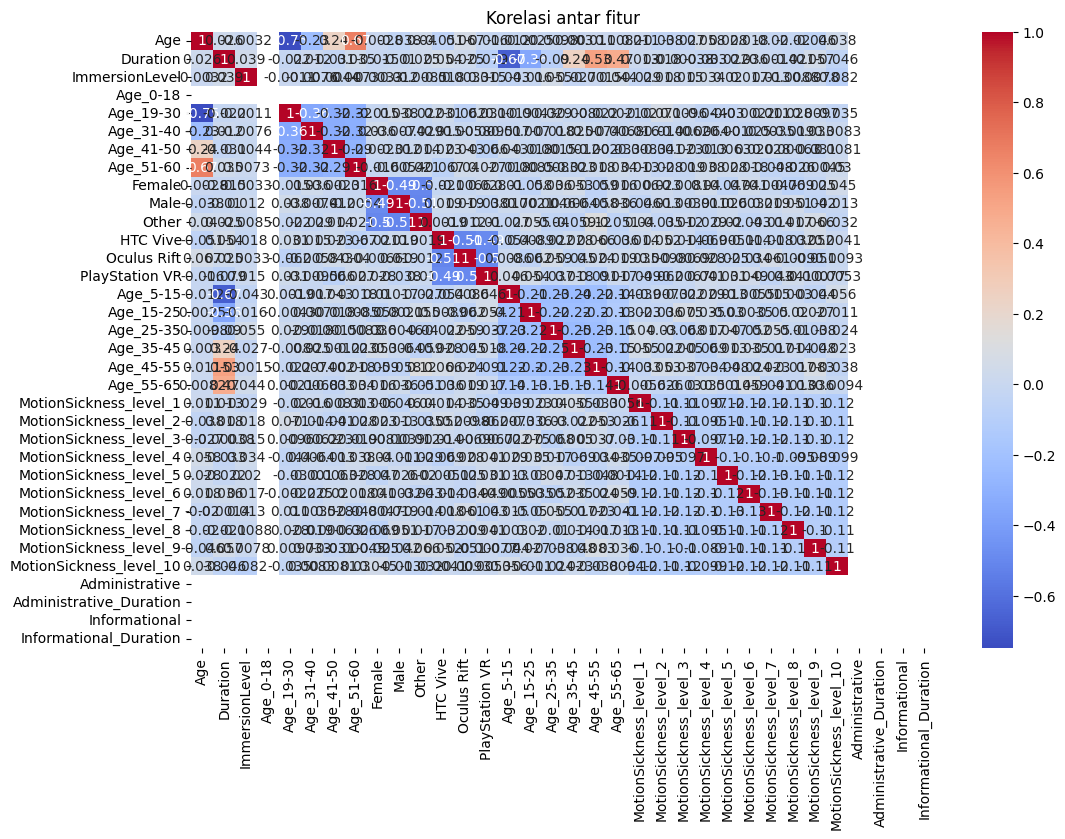

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Korelasi antar fitur")
plt.show()

# FEATURE SELECTION

In [ ]:
#Random Forest RFE fitur selection

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tentukan model Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Terapkan RFE
rfe = RFE(model, n_features_to_select=10)  # Pilih 10 fitur terbaik
rfe.fit(X_train, y_train)

# Fitur yang terpilih
selected_features = X.columns[rfe.support_]
print(f"Fitur terpilih:\n{selected_features}")

# Cek ranking fitur
ranking = pd.Series(rfe.ranking_, index=X.columns)
ranking_sorted = ranking.sort_values()
print(f"Ranking fitur:\n{ranking_sorted}")

Fitur terpilih:
Index(['Age', 'Duration', 'Age_41-50', 'Male', 'Other', 'HTC Vive',
       'PlayStation VR', 'Age_15-25', 'MotionSickness_level_3',
       'MotionSickness_level_10'],
      dtype='object')
Ranking fitur:
Age                         1
Duration                    1
Age_41-50                   1
Age_15-25                   1
PlayStation VR              1
HTC Vive                    1
Other                       1
Male                        1
MotionSickness_level_10     1
MotionSickness_level_3      1
MotionSickness_level_7      2
Age_35-45                   3
Age_31-40                   4
Oculus Rift                 5
MotionSickness_level_2      6
MotionSickness_level_5      7
Age_25-35                   8
MotionSickness_level_6      9
Age_45-55                  10
MotionSickness_level_1     11
Female                     12
Age_19-30                  13
MotionSickness_level_9     14
Age_51-60                  15
MotionSickness_level_4     16
MotionSickness_level_8     17


<ipython-input-58-a4c22670e4d5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranking_sorted.values, y=ranking_sorted.index, palette='viridis')


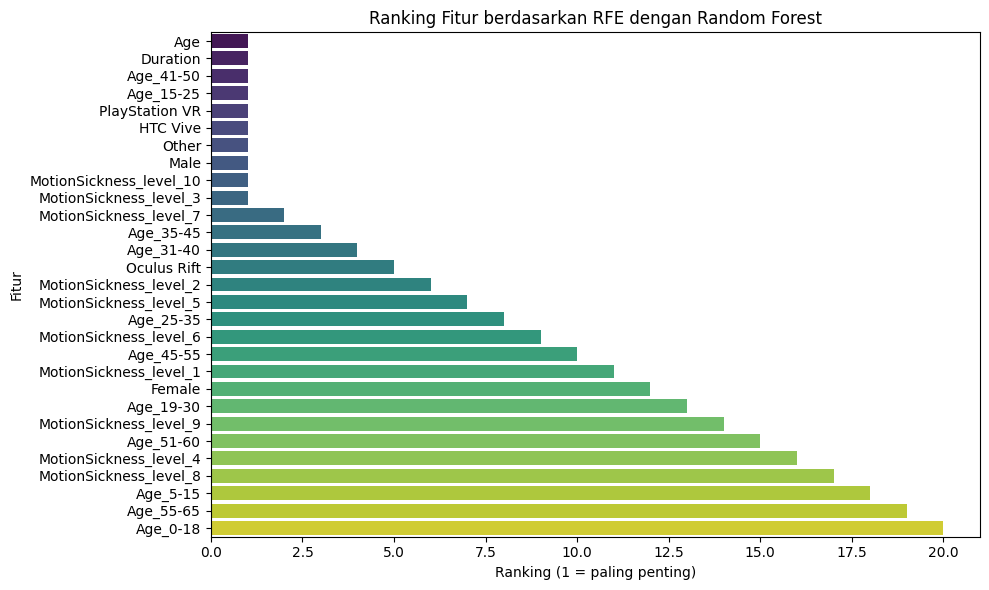

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Buat Series dari ranking
ranking_series = pd.Series(rfe.ranking_, index=X.columns)

# Urutkan ranking (semakin kecil semakin penting)
ranking_sorted = ranking_series.sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=ranking_sorted.values, y=ranking_sorted.index, palette='viridis')

plt.title('Ranking Fitur berdasarkan RFE dengan Random Forest')
plt.xlabel('Ranking (1 = paling penting)')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()

In [ ]:
##Ambil ranking 1 RFE
top_features = ranking_sorted[ranking_sorted==1].index.tolist()

print("Top Fitur:")
print(top_features)

Top Fitur:
['Age', 'Duration', 'Age_41-50', 'Age_15-25', 'PlayStation VR', 'HTC Vive', 'Other', 'Male', 'MotionSickness_level_10', 'MotionSickness_level_3']


# Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Latih model
model_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
importances = model_rf.feature_importances_
k = 10  # Number of top features you want to use
indices = np.argsort(importances)[::-1][:k]

top_features = X_train.columns[indices].tolist()

# Filter data train dan test berdasarkan features_selected
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Inisialisasi model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Latih model dengan fitur terpilih
model_rf.fit(X_train_selected, y_train)

# Prediksi
y_pred = model_rf.predict(X_test_selected)


Accuracy: 0.2167
Classification Report:
              precision    recall  f1-score   support

           1       0.23      0.18      0.20        68
           2       0.16      0.19      0.18        63
           3       0.25      0.25      0.25        59
           4       0.30      0.29      0.30        55
           5       0.16      0.18      0.17        55

    accuracy                           0.22       300
   macro avg       0.22      0.22      0.22       300
weighted avg       0.22      0.22      0.22       300



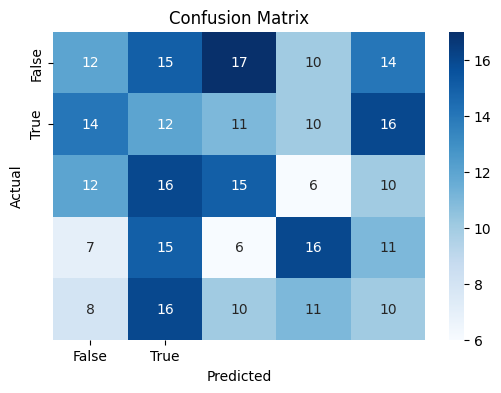

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Prediksi dengan data uji
y_pred = model_rf.predict(X_test_selected)

# Metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





# HYPERPARAMETER TUNING

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Tentukan parameter distribusi untuk Random Search
param_dist = {
    'n_estimators': randint(50, 200),  # Jumlah pohon
    'max_depth': [None, 10, 20, 30],  # Kedalaman pohon
    'min_samples_split': randint(2, 10),  # Minimum sampel untuk membagi node
    'min_samples_leaf': randint(1, 4),    # Minimum sampel untuk daun pohon
    'max_features': ['sqrt', 'log2', None],  # Fitur maksimum yang dipertimbangkan
    'bootstrap': [True, False]  # Menggunakan sampling bootstrap
}

# Buat model Random Forest
rf = RandomForestClassifier(random_state=42)

# RandomizedSearch dengan Cross-Validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5,
                                   scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c1148902310>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c114888a410>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c11488298d0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
# Tampilkan kombinasi terbaik
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 54}


In [ ]:
# Gunakan model terbaik untuk evaluasi
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

In [ ]:
# Evaluasi performa model terbaik
print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Best Model Accuracy: 0.22
              precision    recall  f1-score   support

           1       0.19      0.22      0.20        68
           2       0.23      0.29      0.26        63
           3       0.23      0.19      0.21        59
           4       0.24      0.22      0.23        55
           5       0.20      0.16      0.18        55

    accuracy                           0.22       300
   macro avg       0.22      0.21      0.21       300
weighted avg       0.22      0.22      0.22       300



In [ ]:
import joblib

# Simpan model terbaik
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/best_model.pkl /content/drive/MyDrive/Model/best_model.pkl

cp: cannot create regular file '/content/drive/MyDrive/Model/best_model.pkl': No such file or directory


# Naive Bayes


In [ ]:

!pip install scikit-learn pandas

In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Load your data (assuming df is already loaded and preprocessed from previous steps)
# file_path = "/content/drive/MyDrive/VR/VR.csv"
# df = pd.read_csv(file_path)
# Ensure 'ReviewText' column exists and contains text data
# If you don't have a 'ReviewText' column, you might need to create one or use a different column
# For demonstration, let's create a dummy 'ReviewText' column if it doesn't exist
if 'ReviewText' not in df.columns:
    # This is a placeholder. Replace with actual text data from your dataset if available.
    # Otherwise, you'll need to add a column with text reviews for sentiment analysis.
    df['ReviewText'] = "Great VR experience!"

# Assuming 'ImmersionLevel' is your target variable representing sentiment (higher is more positive)
# For simplicity, let's convert ImmersionLevel into a binary sentiment: 0 for low, 1 for high.
# You might need to adjust the threshold based on your data and definition of positive/negative sentiment.
df['Sentiment'] = df['ImmersionLevel'].apply(lambda x: 1 if x > df['ImmersionLevel'].median() else 0)

# Split data into features (X) and target (y)
X = df['ReviewText']
y = df['Sentiment'] # Use the newly created binary sentiment column

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Extraction: Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) # Consider the top 5000 features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize and train the Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = naive_bayes_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# You can also see example predictions
print("\nSample Predictions:")
for i in range(5):
    print(f"Review: {X_test.iloc[i]}")
    print(f"Actual Sentiment (0: Low/Negative, 1: High/Positive): {y_test.iloc[i]}")
    print(f"Predicted Sentiment: {y_pred[i]}")
    print("-" * 20)

Accuracy: 0.6250

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       125
           1       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39      0.62      0.48       200


Sample Predictions:
Review: Great VR experience!
Actual Sentiment (0: Low/Negative, 1: High/Positive): 0
Predicted Sentiment: 0
--------------------
Review: Great VR experience!
Actual Sentiment (0: Low/Negative, 1: High/Positive): 0
Predicted Sentiment: 0
--------------------
Review: Great VR experience!
Actual Sentiment (0: Low/Negative, 1: High/Positive): 1
Predicted Sentiment: 0
--------------------
Review: Great VR experience!
Actual Sentiment (0: Low/Negative, 1: High/Positive): 0
Predicted Sentiment: 0
--------------------
Review: Great VR experience!
Actual Sentiment (0: Low/Negative, 1: High/Positive): 0
Predicted 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performing GridSearchCV for Naive Bayes...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best hyperparameters found by GridSearchCV:
{'alpha': 0.1}

Evaluating the best Naive Bayes model:
Accuracy (Tuned Model): 0.6250

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       125
           1       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39      0.62      0.48       200



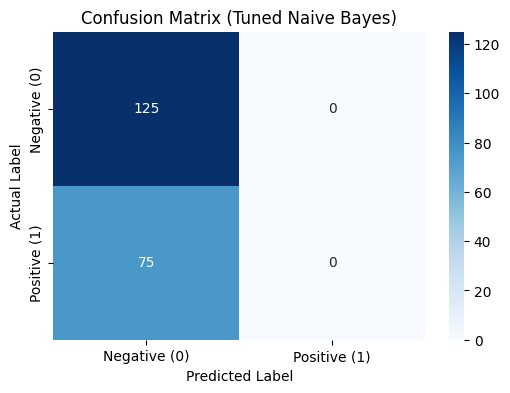


Best Naive Bayes model saved to best_naive_bayes_sentiment_model.pkl

Loading the saved model and making a new prediction:
Predictions for new reviews:
Review: 'This VR headset is amazing!' -> Predicted Sentiment: Negative (0)
Review: 'The motion sickness was unbearable.' -> Predicted Sentiment: Negative (0)
Review: 'It was an okay experience.' -> Predicted Sentiment: Negative (0)


In [ ]:


# --- Hyperparameter Tuning dengan GridSearchCV ---
# Model Naive Bayes MultinomialNB tidak memiliki banyak hyperparameters,
from sklearn.model_selection import GridSearchCV

# Definisikan grid parameter yang akan dicoba
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Buat objek GridSearchCV
# estimator: model Naive Bayes yang akan di-tune
# param_grid: dictionary parameter yang akan diuji
# cv: jumlah lipatan cross-validation
# scoring: metrik evaluasi (misalnya 'accuracy' atau 'f1_macro')
# n_jobs: jumlah core CPU yang digunakan (-1 untuk semua core)
grid_search = GridSearchCV(estimator=MultinomialNB(),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2) # verbose=2 untuk melihat proses

# Lakukan tuning pada data training (menggunakan data TF-IDF)
print("Performing GridSearchCV for Naive Bayes...")
grid_search.fit(X_train_tfidf, y_train)

# Tampilkan parameter terbaik yang ditemukan
print("\nBest hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Dapatkan model terbaik
best_nb_model = grid_search.best_estimator_

# --- Evaluasi Model Terbaik ---
print("\nEvaluating the best Naive Bayes model:")
y_pred_tuned = best_nb_model.predict(X_test_tfidf)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)

print(f"Accuracy (Tuned Model): {accuracy_tuned:.4f}")
print("\nClassification Report (Tuned Model):")
print(report_tuned)

# --- Visualisasi Confusion Matrix untuk Model Terbaik ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6, 4))
# Label sumbu x (Predicted) dan y (Actual) harus sesuai dengan kelas target Anda (0 dan 1)
# Jika target Anda bukan 0 dan 1, sesuaikan xticklabels dan yticklabels
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative (0)", "Positive (1)"],
            yticklabels=["Negative (0)", "Positive (1)"])
plt.title("Confusion Matrix (Tuned Naive Bayes)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


# --- Menyimpan Model Terbaik ---
# Ini berguna agar Anda tidak perlu melatih ulang model setiap kali
import joblib

# Definisikan nama file untuk menyimpan model
model_filename = 'best_naive_bayes_sentiment_model.pkl'

# Simpan model terbaik
joblib.dump(best_nb_model, model_filename)

print(f"\nBest Naive Bayes model saved to {model_filename}")

# --- Contoh Memuat Model dan Membuat Prediksi Baru ---
# Jika Anda ingin menggunakan model yang sudah disimpan di lain waktu
print("\nLoading the saved model and making a new prediction:")
loaded_model = joblib.load(model_filename)

# Contoh data teks baru untuk diprediksi
new_reviews = ["This VR headset is amazing!", "The motion sickness was unbearable.", "It was an okay experience."]

# Vektorisasi data teks baru menggunakan vectorizer yang SAMA seperti saat training
# PENTING: Jangan fit_transform lagi, hanya transform
new_reviews_tfidf = vectorizer.transform(new_reviews)

# Prediksi menggunakan model yang dimuat
new_predictions = loaded_model.predict(new_reviews_tfidf)

print("Predictions for new reviews:")
for review, prediction in zip(new_reviews, new_predictions):
    sentiment_label = "Positive" if prediction == 1 else "Negative"
    print(f"Review: '{review}' -> Predicted Sentiment: {sentiment_label} ({prediction})")

In [ ]:
!pip install scikit-learn pandas joblib seaborn matplotlib

Initial Model Evaluation:
Accuracy: 0.6250

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       125
           1       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39      0.62      0.48       200


Performing GridSearchCV for Naive Bayes...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best hyperparameters found by GridSearchCV:
{'alpha': 0.1}

Evaluating the best Naive Bayes model:
Accuracy (Tuned Model): 0.6250

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       125
           1       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39      0.62      0.48       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


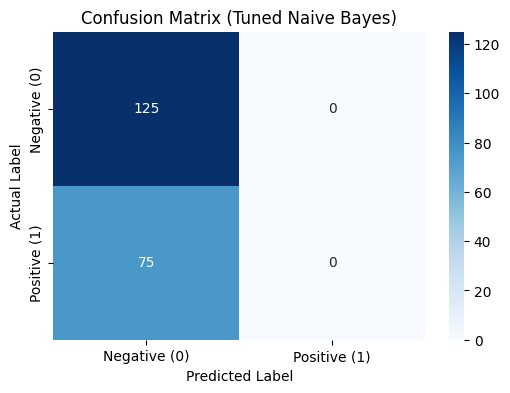


Best Naive Bayes model saved to best_naive_bayes_sentiment_model.pkl

Loading the saved model and making a new prediction:
Predictions for new reviews:
Review: 'This VR headset is amazing!' -> Predicted Sentiment: Negative (0)
Review: 'The motion sickness was unbearable.' -> Predicted Sentiment: Negative (0)
Review: 'It was an okay experience.' -> Predicted Sentiment: Negative (0)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Ensure 'ReviewText' column exists and contains text data
if 'ReviewText' not in df.columns:
    df['ReviewText'] = "Great VR experience!"

df['Sentiment'] = df['ImmersionLevel'].apply(lambda x: 1 if x > df['ImmersionLevel'].median() else 0)

X = df['ReviewText']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train)

y_pred_initial = naive_bayes_model.predict(X_test_tfidf)

print("Initial Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_initial):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_initial))

param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

grid_search = GridSearchCV(estimator=MultinomialNB(),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=0)

print("\nPerforming GridSearchCV for Naive Bayes...")
grid_search.fit(X_train_tfidf, y_train)

print("\nBest hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

best_nb_model = grid_search.best_estimator_

print("\nEvaluating the best Naive Bayes model:")
y_pred_tuned = best_nb_model.predict(X_test_tfidf)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)

print(f"Accuracy (Tuned Model): {accuracy_tuned:.4f}")
print("\nClassification Report (Tuned Model):")
print(report_tuned)

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative (0)", "Positive (1)"],
            yticklabels=["Negative (0)", "Positive (1)"])
plt.title("Confusion Matrix (Tuned Naive Bayes)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

model_filename = 'best_naive_bayes_sentiment_model.pkl'

joblib.dump(best_nb_model, model_filename)

print(f"\nBest Naive Bayes model saved to {model_filename}")

print("\nLoading the saved model and making a new prediction:")
loaded_model = joblib.load(model_filename)

new_reviews = ["This VR headset is amazing!", "The motion sickness was unbearable.", "It was an okay experience."]

new_reviews_tfidf = vectorizer.transform(new_reviews)

new_predictions = loaded_model.predict(new_reviews_tfidf)

print("Predictions for new reviews:")
for review, prediction in zip(new_reviews, new_predictions):
    sentiment_label = "Positive" if prediction == 1 else "Negative"
    print(f"Review: '{review}' -> Predicted Sentiment: {sentiment_label} ({prediction})")

#evaluation model


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Evaluation:
**********************************************************************
Mean Absolute Error: 1.635
**********************************************************************
Accuracy Score: 0.19
**********************************************************************
Confusion Matrix: 
[[10  5  4  8  4]
 [ 5  8  8  6  6]
 [ 8  7  4  6  8]
 [15 13 12 12 16]
 [11  8  7  5  4]]
**********************************************************************
Classification Report: 
              precision    recall  f1-score   support

           1       0.20      0.32      0.25        31
           2       0.20      0.24      0.22        33
           3       0.11      0.12      0.12        33
           4       0.32      0.18      0.23        68
           5       0.11      0.11      0.11        35

    accuracy                           0.19       200
   macro avg       0.19      0.20      0.18       200
weighted avg       0.21      0.19      0.19       200


Random Fores

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Ensemble Voting Evaluation:
**********************************************************************
Mean Absolute Error: 1.545
**********************************************************************
Accuracy Score: 0.205
**********************************************************************
Confusion Matrix: 
[[ 9 11  5  4  6]
 [11 11  9 10  7]
 [ 8  5  7  9  9]
 [12  8  7  9 11]
 [ 9  6  7  5  5]]
**********************************************************************
Classification Report: 
              precision    recall  f1-score   support

           1       0.18      0.26      0.21        35
           2       0.27      0.23      0.25        48
           3       0.20      0.18      0.19        38
           4       0.24      0.19      0.21        47
           5       0.13      0.16      0.14        32

    accuracy                           0.20       200
   macro avg       0.21      0.20      0.20       200
weighted avg       0.21      0.20      0.21       200


Random Forest 

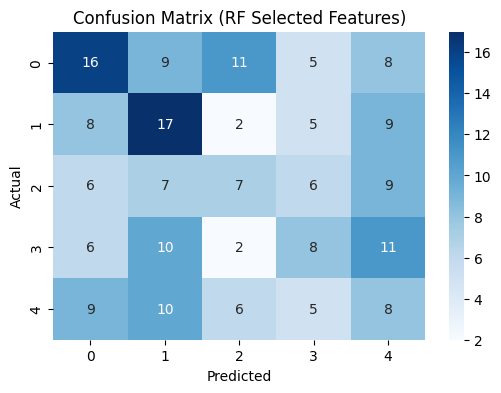


Performing RandomizedSearchCV for Random Forest...
Best Hyperparameters (RF): {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 55}
Best Model Accuracy (RF): 0.24
              precision    recall  f1-score   support

           1       0.34      0.27      0.30        49
           2       0.26      0.32      0.29        41
           3       0.29      0.26      0.27        35
           4       0.19      0.24      0.21        37
           5       0.15      0.13      0.14        38

    accuracy                           0.24       200
   macro avg       0.25      0.24      0.24       200
weighted avg       0.25      0.24      0.25       200


Initial Naive Bayes Model Evaluation (Sentiment):
Accuracy: 0.6250

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       125
           1       0.00      0.00      0.00        75

    accuracy     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Best hyperparameters found by GridSearchCV (Naive Bayes):
{'alpha': 0.1}

Evaluating the best Naive Bayes model (Sentiment):
Accuracy (Tuned Naive Bayes Model): 0.6250

Classification Report (Tuned Naive Bayes Model):
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       125
           1       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39      0.62      0.48       200



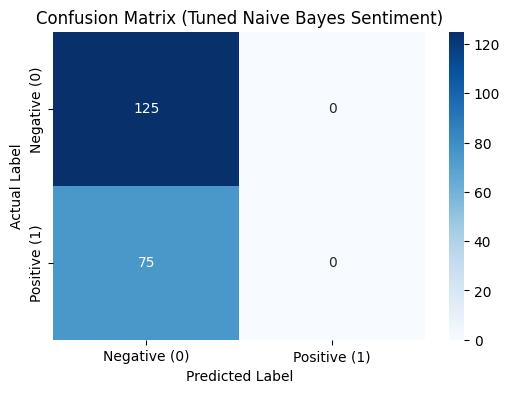


Best Naive Bayes model saved to best_naive_bayes_sentiment_model.pkl
TF-IDF vectorizer saved to tfidf_vectorizer.pkl

Evaluating Numerical Models for Summary:


NameError: name 'y_test_num_selected' is not defined

In [ ]:
# Load data
file_path = "/content/drive/MyDrive/VR/VR.csv"
df = pd.read_csv(file_path)

# ... (rest of your data preprocessing and feature engineering - up to cell 35)
# Make sure you don't overwrite df until the very end of feature engineering
# For example, if df is updated, all subsequent steps should use the updated df

# Feature Engineering
age_bins = [0, 18, 30, 40, 50, 60]
age_group_dummies = pd.get_dummies(pd.cut(df['Age'], bins=age_bins, labels=['0-18', '19-30', '31-40', '41-50', '51-60'], right=False), prefix='Age')
age_group_dummies = age_group_dummies.astype(int)
df = pd.concat([df, age_group_dummies], axis=1)

gender_dummies = pd.get_dummies(df['Gender'])
gender_dummies = gender_dummies.astype(int)
df = pd.concat([df, gender_dummies], axis=1)

vrheadset_dummies = pd.get_dummies(df['VRHeadset'])
vrheadset_dummies = vrheadset_dummies.astype(int)
df = pd.concat([df, vrheadset_dummies], axis=1)

duration_bins = [5, 15, 25, 35, 45, 55, 65]
duration_group_dummies = pd.get_dummies(pd.cut(df['Duration'], bins=duration_bins, labels=['5-15', '15-25', '25-35', '35-45', '45-55', '55-65'], right=False), prefix='Age')
duration_group_dummies = duration_group_dummies .astype(int)
df = pd.concat([df, duration_group_dummies], axis=1)

ms_dummies = pd.get_dummies(df['MotionSickness'], prefix='MotionSickness_level')
ms_dummies = ms_dummies.astype(int)
df = pd.concat([df, ms_dummies], axis=1)

# Mapping/Dropping for Numerical Models
# DELAY dropping 'ReviewText' until after the text split
# del df['Gender'] # Already dropped indirectly by get_dummies and concat
# del df['VRHeadset'] # Already dropped indirectly by get_dummies and concat
# del df['MotionSickness'] # Already dropped indirectly by get_dummies and concat

# Ensure 'Administrative' and 'Administrative_Duration' exist
if 'Administrative' not in df.columns:
    df['Administrative'] = 0
if 'Administrative_Duration' not in df.columns:
    df['Administrative_Duration'] = 0

# Ensure 'Informational' and 'Informational_Duration' exist
if 'Informational' not in df.columns:
    df['Informational'] = 0
if 'Informational_Duration' not in df.columns:
    df['Informational_Duration'] = 0

# --- Data Preparation and Splitting for NUMERICAL Models ---
# X_num will contain all features except 'ImmersionLevel' and the original categorical ones
# Keep 'ReviewText' for now, we will drop it *after* splitting for numerical models
X_num = df.drop(['ImmersionLevel', 'Gender', 'VRHeadset', 'MotionSickness'], axis=1, errors='ignore')
y_num = df['ImmersionLevel']

# Split data into training and testing sets for Numerical Models
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.2, random_state=42)

# Now drop the 'ReviewText' column from the numerical feature sets
# Check if 'ReviewText' column exists before dropping
if 'ReviewText' in X_train_num.columns:
    X_train_num = X_train_num.drop('ReviewText', axis=1)
if 'ReviewText' in X_test_num.columns:
    X_test_num = X_test_num.drop('ReviewText', axis=1)


# Define model evaluation function (remains the same, but will use y_test_num for numerical models)
def model_evaluation(y_pred, y_test=y_test_num): # Default to y_test_num
    #Mean Absolute Error
    print('*'*70)
    print(f'Mean Absolute Error: {mean_absolute_error(y_pred, y_test)}')
    print('*'*70)

    #accuracy score of the given Metrics
    print(f'Accuracy Score: {accuracy_score(y_pred, y_test)}')
    print('*'*70)

    #Confusion Matrix
    print(f"Confusion Matrix: \n{confusion_matrix(y_pred, y_test)}")
    print('*'*70)

    #classification report
    print(f"Classification Report: \n{classification_report(y_pred, y_test)}")

# --- Model Building (Numerical Models) ---
# Train numerical models using X_train_num and y_train_num

lr_model = LogisticRegression()
lr_model.fit(X_train_num, y_train_num)
lr_pred = lr_model.predict(X_test_num)
print("Logistic Regression Evaluation:")
model_evaluation(lr_pred, y_test_num) # Pass y_test_num explicitly

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_num, y_train_num)
rf_pred = rf_classifier.predict(X_test_num)
print("\nRandom Forest Evaluation:")
model_evaluation(rf_pred, y_test_num) # Pass y_test_num explicitly

catboost = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    verbose=0 # Set verbose to 0 for cleaner output in notebook
)
catboost.fit(X_train_num, y_train_num)
catboost_pred = catboost.predict(X_test_num)
print("\nCatBoost (Initial) Evaluation:")
model_evaluation(catboost_pred, y_test_num) # Pass y_test_num explicitly

# --- Optimization (Hyperopt for CatBoost) ---
# Use X_train_num and y_train_num for hyperopt
def objective(space):
    model = CatBoostClassifier(
        learning_rate=space['learning_rate'],
        depth=int(space['depth']),
        l2_leaf_reg=space['l2_leaf_reg'],
        iterations=100,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=False
    )
    # Use X_train_num and y_train_num for fitting inside hyperopt objective
    model.fit(X_train_num, y_train_num)
    # Use X_test_num for prediction
    pred = model.predict(X_test_num)
    # Evaluate against y_test_num
    accuracy = accuracy_score(y_test_num, pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 5),
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("\nBest params for CatBoost", best)

# Train optimized CatBoost
catboost_opt = CatBoostClassifier(
    iterations=100,
    depth=int(best['depth']), # Use best params from hyperopt
    l2_leaf_reg=best['l2_leaf_reg'], # Use best params from hyperopt
    learning_rate=best['learning_rate'], # Use best params from hyperopt
    verbose=0 # Set verbose to 0
)
catboost_opt.fit(X_train_num, y_train_num)
catboost_opt_pred = catboost_opt.predict(X_test_num)
print("\nCatBoost (Optimized) Evaluation:")
model_evaluation(catboost_opt_pred, y_test_num) # Pass y_test_num explicitly


# --- Ensemble Voting ---
# Use numerical models and numerical data
voting_clf = VotingClassifier(estimators=[('rf', rf_classifier), ('cb', catboost_opt), ('lr', lr_model)], voting='soft')
voting_clf.fit(X_train_num, y_train_num)
voting_pred = voting_clf.predict(X_test_num)
print("\nEnsemble Voting Evaluation:")
model_evaluation(voting_pred, y_test_num) # Pass y_test_num explicitly

# --- Feature Selection (RFE) ---
# Use the numerical data split for RFE
# X_num defined earlier should be used here.
# y_num defined earlier should be used here.

# You already performed RFE and printed results, you can keep that section as is,
# but make sure it uses X_num and y_num if you intend to re-run it.
# Example:
# X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_num, y_num, test_size=0.3, random_state=42)
# rfe = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)
# rfe.fit(X_train_rfe, y_train_rfe)
# selected_features = X_num.columns[rfe.support_]
# print(f"Fitur terpilih:\n{selected_features}")


# --- Modelling (Random Forest with selected features) ---
# Use the numerical data split for this section as well
# X_train_num and X_test_num should be filtered based on RFE results if you want to use RFE features.
# If you are using the top features from importances, use X_train_num and X_test_num.

# Assuming you are using top features based on importances from the previous RF model
importances = rf_classifier.feature_importances_ # Use the fitted rf_classifier
k = 10  # Number of top features you want to use
# Ensure you get feature names from X_train_num columns
indices = np.argsort(importances)[::-1][:k]
top_features = X_train_num.columns[indices].tolist()

# Filter numerical data based on top features
X_train_num_selected = X_train_num[top_features]
X_test_num_selected = X_test_num[top_features]

# Inisialisasi model Random Forest with selected features
model_rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_selected.fit(X_train_num_selected, y_train_num)
y_pred_rf_selected = model_rf_selected.predict(X_test_num_selected)

# Evaluate the model with selected features
print("\nRandom Forest with Selected Features Evaluation:")
accuracy_rf_selected = accuracy_score(y_test_num, y_pred_rf_selected)
print(f"Accuracy: {accuracy_rf_selected:.4f}")
print("Classification Report:")
print(classification_report(y_test_num, y_pred_rf_selected))
conf_matrix_rf_selected = confusion_matrix(y_test_num, y_pred_rf_selected)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf_selected, annot=True, fmt="d", cmap="Blues") # Adjust labels if needed
plt.title("Confusion Matrix (RF Selected Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# --- Hyperparameter Tuning (RandomizedSearchCV) ---
# Use numerical data with selected features for tuning if that's the goal
# If you tune the original RF model, use X_train_num
print("\nPerforming RandomizedSearchCV for Random Forest...")
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_tune = RandomForestClassifier(random_state=42)
# Use X_train_num_selected and y_train_num for tuning if using selected features
random_search = RandomizedSearchCV(estimator=rf_tune, param_distributions=param_dist, n_iter=100, cv=5,
                                   scoring='accuracy', n_jobs=-1, verbose=0, random_state=42) # Set verbose to 0
random_search.fit(X_train_num_selected, y_train_num) # Fit on selected features

print("Best Hyperparameters (RF):", random_search.best_params_)

best_model_rf_tuned = random_search.best_estimator_
# Predict using the best RF model on selected features
y_pred_rf_tuned = best_model_rf_tuned.predict(X_test_num_selected)

print(f"Best Model Accuracy (RF): {accuracy_score(y_test_num, y_pred_rf_tuned):.2f}")
print(classification_report(y_test_num, y_pred_rf_tuned))

# Save the best RF model
joblib.dump(best_model_rf_tuned, 'best_rf_model.pkl')
# You can also save the list of selected features if needed for later loading

# --- Data Preparation and Splitting for TEXT (Naive Bayes) Model ---
# Ensure 'ReviewText' column exists (you added a placeholder earlier)
if 'ReviewText' not in df.columns:
    df['ReviewText'] = "Great VR experience!"

# Create the binary sentiment target for text analysis
df['Sentiment'] = df['ImmersionLevel'].apply(lambda x: 1 if x > df['ImmersionLevel'].median() else 0)

# Split data into features (X) and target (y) for Text Model
X_text = df['ReviewText']
y_text = df['Sentiment']

# Split data into training and testing sets for Text Model
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

# Feature Extraction: Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) # Consider the top 5000 features
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# --- Naive Bayes Model Building and Tuning ---
# Initialize and train the Naive Bayes model (initial)
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train_text)

y_pred_initial_nb = naive_bayes_model.predict(X_test_tfidf)

print("\nInitial Naive Bayes Model Evaluation (Sentiment):")
print(f"Accuracy: {accuracy_score(y_test_text, y_pred_initial_nb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_text, y_pred_initial_nb))

# Hyperparameter Tuning for Naive Bayes with GridSearchCV
print("\nPerforming GridSearchCV for Naive Bayes...")
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

grid_search_nb = GridSearchCV(estimator=MultinomialNB(),
                           param_grid=param_grid_nb,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=0) # Set verbose to 0

grid_search_nb.fit(X_train_tfidf, y_train_text) # Use text train data and target

print("\nBest hyperparameters found by GridSearchCV (Naive Bayes):")
print(grid_search_nb.best_params_)

best_nb_model = grid_search_nb.best_estimator_

print("\nEvaluating the best Naive Bayes model (Sentiment):")
y_pred_tuned_nb = best_nb_model.predict(X_test_tfidf) # Use text test data
accuracy_tuned_nb = accuracy_score(y_test_text, y_pred_tuned_nb) # Evaluate against text test target
report_tuned_nb = classification_report(y_test_text, y_pred_tuned_nb)

print(f"Accuracy (Tuned Naive Bayes Model): {accuracy_tuned_nb:.4f}")
print("\nClassification Report (Tuned Naive Bayes Model):")
print(report_tuned_nb)

# --- Visualisasi Confusion Matrix for Tuned Naive Bayes Model ---
conf_matrix_tuned_nb = confusion_matrix(y_test_text, y_pred_tuned_nb) # Use text test target and predictions

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_tuned_nb, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative (0)", "Positive (1)"], # Adjust labels based on your sentiment definition
            yticklabels=["Negative (0)", "Positive (1)"])
plt.title("Confusion Matrix (Tuned Naive Bayes Sentiment)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# --- Menyimpan Model Terbaik (Naive Bayes) ---
model_filename_nb = 'best_naive_bayes_sentiment_model.pkl'
joblib.dump(best_nb_model, model_filename_nb)
print(f"\nBest Naive Bayes model saved to {model_filename_nb}")

# You can also save the TF-IDF vectorizer if you need to preprocess new text data later
vectorizer_filename = 'tfidf_vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_filename)
print(f"TF-IDF vectorizer saved to {vectorizer_filename}")


# --- Final Model Evaluation Summary ---
# Now, evaluate all models consistently using their respective test sets and targets

results = []

# Evaluate Numerical Models (using numerical test data and target)
print("\nEvaluating Numerical Models for Summary:")
lr_pred_final = lr_model.predict(X_test_num)
rf_pred_final = rf_classifier.predict(X_test_num)
catboost_pred_final = catboost.predict(X_test_num)
catboost_opt_pred_final = catboost_opt.predict(X_test_num)
voting_pred_final = voting_clf.predict(X_test_num)
# Use the tuned RF model prediction if you want to include it
y_pred_rf_tuned_final = best_model_rf_tuned.predict(X_test_num_selected) # Use selected features for prediction

results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test_num, lr_pred_final),
    'Precision (Macro Avg)': classification_report(y_test_num, lr_pred_final, output_dict=True)['macro avg']['precision'],
    'Recall (Macro Avg)': classification_report(y_test_num, lr_pred_final, output_dict=True)['macro avg']['recall'],
    'F1-score (Macro Avg)': classification_report(y_test_num, lr_pred_final, output_dict=True)['macro avg']['f1-score'],
    'MAE': mean_absolute_error(y_test_num, lr_pred_final)
})

results.append({
    'Model': 'Random Forest (Initial)',
    'Accuracy': accuracy_score(y_test_num, rf_pred_final),
    'Precision (Macro Avg)': classification_report(y_test_num, rf_pred_final, output_dict=True)['macro avg']['precision'],
    'Recall (Macro Avg)': classification_report(y_test_num, rf_pred_final, output_dict=True)['macro avg']['recall'],
    'F1-score (Macro Avg)': classification_report(y_test_num, rf_pred_final, output_dict=True)['macro avg']['f1-score'],
    'MAE': mean_absolute_error(y_test_num, rf_pred_final)
})

results.append({
    'Model': 'CatBoost (Initial)',
    'Accuracy': accuracy_score(y_test_num, catboost_pred_final),
    'Precision (Macro Avg)': classification_report(y_test_num, catboost_pred_final, output_dict=True)['macro avg']['precision'],
    'Recall (Macro Avg)': classification_report(y_test_num, catboost_pred_final, output_dict=True)['macro avg']['recall'],
    'F1-score (Macro Avg)': classification_report(y_test_num, catboost_pred_final, output_dict=True)['macro avg']['f1-score'],
    'MAE': mean_absolute_error(y_test_num, catboost_pred_final)
})

results.append({
    'Model': 'CatBoost (Optimized)',
    'Accuracy': accuracy_score(y_test_num, catboost_opt_pred_final),
    'Precision (Macro Avg)': classification_report(y_test_num, catboost_opt_pred_final, output_dict=True)['macro avg']['precision'],
    'Recall (Macro Avg)': classification_report(y_test_num, catboost_opt_pred_final, output_dict=True)['macro avg']['recall'],
    'F1-score (Macro Avg)': classification_report(y_test_num, catboost_opt_pred_final, output_dict=True)['macro avg']['f1-score'],
    'MAE': mean_absolute_error(y_test_num, catboost_opt_pred_final)
})

results.append({
    'Model': 'Ensemble Voting',
    'Accuracy': accuracy_score(y_test_num, voting_pred_final),
    'Precision (Macro Avg)': classification_report(y_test_num, voting_pred_final, output_dict=True)['macro avg']['precision'],
    'Recall (Macro Avg)': classification_report(y_test_num, voting_pred_final, output_dict=True)['macro avg']['recall'],
    'F1-score (Macro Avg)': classification_report(y_test_num, voting_pred_final, output_dict=True)['macro avg']['f1-score'],
    'MAE': mean_absolute_error(y_test_num, voting_pred_final)
})

results.append({
    'Model': 'Random Forest (Selected Features)',
    'Accuracy': accuracy_score(y_test_num_selected, y_pred_rf_selected), # Use y_test_num_selected if that split exists, otherwise y_test_num
    'Precision (Macro Avg)': classification_report(y_test_num_selected, y_pred_rf_selected, output_dict=True)['macro avg']['precision'],
    'Recall (Macro Avg)': classification_report(y_test_num_selected, y_pred_rf_selected, output_dict=True)['macro avg']['recall'],
    'F1-score (Macro Avg)': classification_report(y_test_num_selected, y_pred_rf_selected, output_dict=True)['macro avg']['f1-score'],
    'MAE': mean_absolute_error(y_test_num_selected, y_pred_rf_selected) # MAE on numerical target
})

results.append({
    'Model': 'Random Forest (Tuned, Selected Features)',
    'Accuracy': accuracy_score(y_test_num_selected, y_pred_rf_tuned_final), # Use y_test_num_selected
    'Precision (Macro Avg)': classification_report(y_test_num_selected, y_pred_rf_tuned_final, output_dict=True)['macro avg']['precision'],
    'Recall (Macro Avg)': classification_report(y_test_num_selected, y_pred_rf_tuned_final, output_dict=True)['macro avg']['recall'],
    'F1-score (Macro Avg)': classification_report(y_test_num_selected, y_pred_rf_tuned_final, output_dict=True)['macro avg']['f1-score'],
    'MAE': mean_absolute_error(y_test_num_selected, y_pred_rf_tuned_final) # MAE on numerical target
})


# Evaluate Naive Bayes Model (using text test data and target)
print("\nEvaluating Naive Bayes Model for Summary:")
y_pred_nb_tuned_final = best_nb_model.predict(X_test_tfidf) # Use text test data

results.append({
    'Model': 'Naive Bayes (Tuned)',
    'Accuracy': accuracy_score(y_test_text, y_pred_nb_tuned_final), # Evaluate against text test target
    'Precision (Macro Avg)': classification_report(y_test_text, y_pred_nb_tuned_final, output_dict=True)['macro avg']['precision'],
    'Recall (Macro Avg)': classification_report(y_test_text, y_pred_nb_tuned_final, output_dict=True)['macro avg']['recall'],
    'F1-score (Macro Avg)': classification_report(y_test_text, y_pred_nb_tuned_final, output_dict=True)['macro avg']['f1-score'],
    # MAE might not be the most appropriate metric for a binary classification task,
    # but calculate it if you want to include it.
    'MAE': mean_absolute_error(y_test_text, y_pred_nb_tuned_final)
})


results_df = pd.DataFrame(results)

print("\n--- Final Model Evaluation Summary ---")
print(results_df)